In [ ]:
dataset_dir = './datasets/keypointrcnn_data'    # output_dir
model_save_path = 'some-model.pt'

# 1. Imports

In [ ]:
import os, json, cv2, numpy as np, matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F

# import albumentations as A # Library for augmentations

In [ ]:
!git clone https://github.com/Blankeos/scoliovis-training.git
%cd scoliovis-training

Cloning into 'scoliovis-training'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 28 (delta 11), reused 24 (delta 7), pack-reused 0
Unpacking objects: 100% (28/28), done.
/content/scoliovis-training


In [ ]:
# Was obtained here: https://github.com/Blankeos/scoliovis-training.git
import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate

# Originally obtained here from the links below but changed `kpt_oks_sigmas` to fit our dataset
# https://github.com/pytorch/vision/tree/main/references/detection or https://github.com/alexppppp/keypoint_rcnn_training_pytorch.git

# 2. Augmentations

In [ ]:
# def train_transform():
#     return A.Compose([
#         A.Sequential([
#             A.RandomRotate90(p=1), # Random rotation of an image by 90 degrees zero or more times
#             A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, brightness_by_max=True, always_apply=False, p=1), # Random change of brightness & contrast
#         ], p=1)
#     ],
#     keypoint_params=A.KeypointParams(format='xy'), # More about keypoint formats used in albumentations library read at https://albumentations.ai/docs/getting_started/keypoints_augmentation/
#     bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels']) # Bboxes should have labels, read more here https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
#     )

# 3. Dataset Class

In [ ]:
'''
__getitem__ 함수 내에서
    img, bboxes, keypoints와 img_original, bboxes_original, keypoints_original의 구분이 명확하지 않아서
    target과 target_original이 같은 내용을 담고 있음
따라서 코드 수정이 필요하다고 생각함 
'''

# class ClassDataset(Dataset):
#     def __init__(self, root, split="val"):
#         self.root = root
#         self.split = split  # val or train
#         self.imgs_files = sorted(os.listdir(os.path.join(root, "images", split))) # string[], 이미지 파일 목록
#         self.annotations_files = sorted(os.listdir(os.path.join(root, "labels", split))) # string[], 주석 파일 목록
#         # self.transform = transform
#         # self.demo = demo # Use demo=True if you need transformed and original images (for example, for visualization purposes)

#     def __getitem__(self, idx):
#         # 특정 idx에 해당하는 이미지 파일, 주석 파일 경로 
#         img_path = os.path.join(self.root, "images", self.split, self.imgs_files[idx])
#         annotations_path = os.path.join(self.root, "labels", self.split, self.annotations_files[idx])

#         img_original = cv2.imread(img_path) # 이미지 읽기
#         img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)    # 색상 형식 : BGR -> RGB

#         with open(annotations_path) as f:   # JSON 파일 형태의 주석 파일 가져오기
#             data = json.load(f)
#             bboxes_original = data['boxes']
#             keypoints_original = data['keypoints']
#             labels_original = data['labels']

#             # label을 'vert'로 설정하는 리스트
#             bboxes_labels_original = ['vert' for _ in bboxes_original]

#         img, bboxes, keypoints = img_original, bboxes_original, keypoints_original

#         # bounding box를 PyTorch 텐서로 변환
#         bboxes = torch.as_tensor(bboxes, dtype=torch.float32)

#         target = {} # 딕셔너리
#         target["boxes"] = bboxes
#         target["labels"] = torch.as_tensor([1 for _ in bboxes], dtype=torch.int64) # all objects are glue tubes
#         target["image_id"] = torch.tensor([idx])
#         target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
#         target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
#         target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)
#         img = F.to_tensor(img)  # 이미지를 PyTorch 텐서로 변환 

#         bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32) # 원본 bounding box를 PyTorch 텐서로 변환
#         target_original = {}
#         target_original["boxes"] = bboxes_original
#         target_original["labels"] = torch.as_tensor([1 for _ in bboxes_original], dtype=torch.int64) # all objects are glue tubes
#         target_original["image_id"] = torch.tensor([idx])
#         target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
#         target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
#         target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)
#         img_original = F.to_tensor(img_original)

#         return img, target

#     def __len__(self):
#         return len(self.imgs_files)

In [ ]:
# 수정하기
# PyTorch의 Dataset 클래스를 상속받아 이미지와 해당하는 주석(bounding box, keypoint 등)을 로드하는 클래스
class ClassDataset(Dataset):
    def __init__(self, root, split="val"):
        self.root = root
        self.split = split  # val or train
        self.imgs_files = sorted(os.listdir(os.path.join(root, "images", split))) # string[], 이미지 파일 목록
        self.annotations_files = sorted(os.listdir(os.path.join(root, "labels", split))) # string[], 주석 파일 목록
        # self.transform = transform
        # self.demo = demo # Use demo=True if you need transformed and original images (for example, for visualization purposes)

    def __getitem__(self, idx):
        # 특정 idx에 해당하는 이미지 파일, 주석 파일 경로 
        img_path = os.path.join(self.root, "images", self.split, self.imgs_files[idx])
        annotations_path = os.path.join(self.root, "labels", self.split, self.annotations_files[idx])

        img_original = cv2.imread(img_path) # 이미지 읽기
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)    # 색상 형식 : BGR -> RGB

        with open(annotations_path) as f:   # JSON 파일 형태의 주석 파일 가져오기
            data = json.load(f)
            bboxes_original = data['boxes']
            keypoints_original = data['keypoints']
            labels_original = data['labels']

            # label을 'vert'로 설정하는 리스트
            bboxes_labels_original = ['vert' for _ in bboxes_original]

        img, bboxes, keypoints = img_original, bboxes_original, keypoints_original

        # bounding box를 PyTorch 텐서로 변환
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)

        target = {} # 딕셔너리
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor([1 for _ in bboxes], dtype=torch.int64) # all objects are glue tubes
        target["image_id"] = torch.tensor([idx])
        target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
        target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)
        img = F.to_tensor(img)  # 이미지를 PyTorch 텐서로 변환 

        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32) # 원본 bounding box를 PyTorch 텐서로 변환
        target_original = {}
        target_original["boxes"] = bboxes_original
        target_original["labels"] = torch.as_tensor([1 for _ in bboxes_original], dtype=torch.int64) # all objects are glue tubes
        target_original["image_id"] = torch.tensor([idx])
        target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)
        img_original = F.to_tensor(img_original)

        return img, target

    # 데이터셋 길이 반환 => 데이터로더가 데이터셋을 반복할 수 있도록 
    def __len__(self):  
        return len(self.imgs_files)

# 4. Visualizing a random item from dataset


In [ ]:
dataset = ClassDataset(dataset_dir, split="val")
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)    # 배치단위로 데이터 로드 
# batch_size=1 : 한 번에 하나의 데이터 항목 로드 
# shuffle=True : 데이터셋을 섞어서 임의의 순서로 배치 데이터 로드, 과적합 방지에 도움
# collate_fn : 배치 데이터를 합치는 방법을 정의하는 함수

iterator = iter(data_loader)    # 배치를 반복적으로 가져오는 데 사용됨
batch = next(iterator)          # 이터레이터에서 다음 배치를 가져옴 

print(f"Image Tensor (X):", batch[0])   # 배치에서 첫 번째 요소, 이미지 텐서
print(f"Targets Dict[Tensor] (y):", batch[1])   # 배치에서 두 번째 요소, 타겟 딕셔너리 

Image Tensor (X): (tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.6039, 0.5922, 0.5765,  ..., 0.4588, 0.4549, 0.4471],
         [0.6039, 0.5882, 0.5686,  ..., 0.4510, 0.4471, 0.4510],
         [0.6039, 0.5843, 0.5647,  ..., 0.4471, 0.4431, 0.4510]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.6039, 0.5922, 0.5765,  ..., 0.4588, 0.4549, 0.4471],
         [0.6039, 0.5882, 0.5686,  ..., 0.4510, 0.4471, 0.4510],
         [0.6039, 0.5843, 0.5647,  ..., 0.4471, 0.4431, 0.4510]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ...,

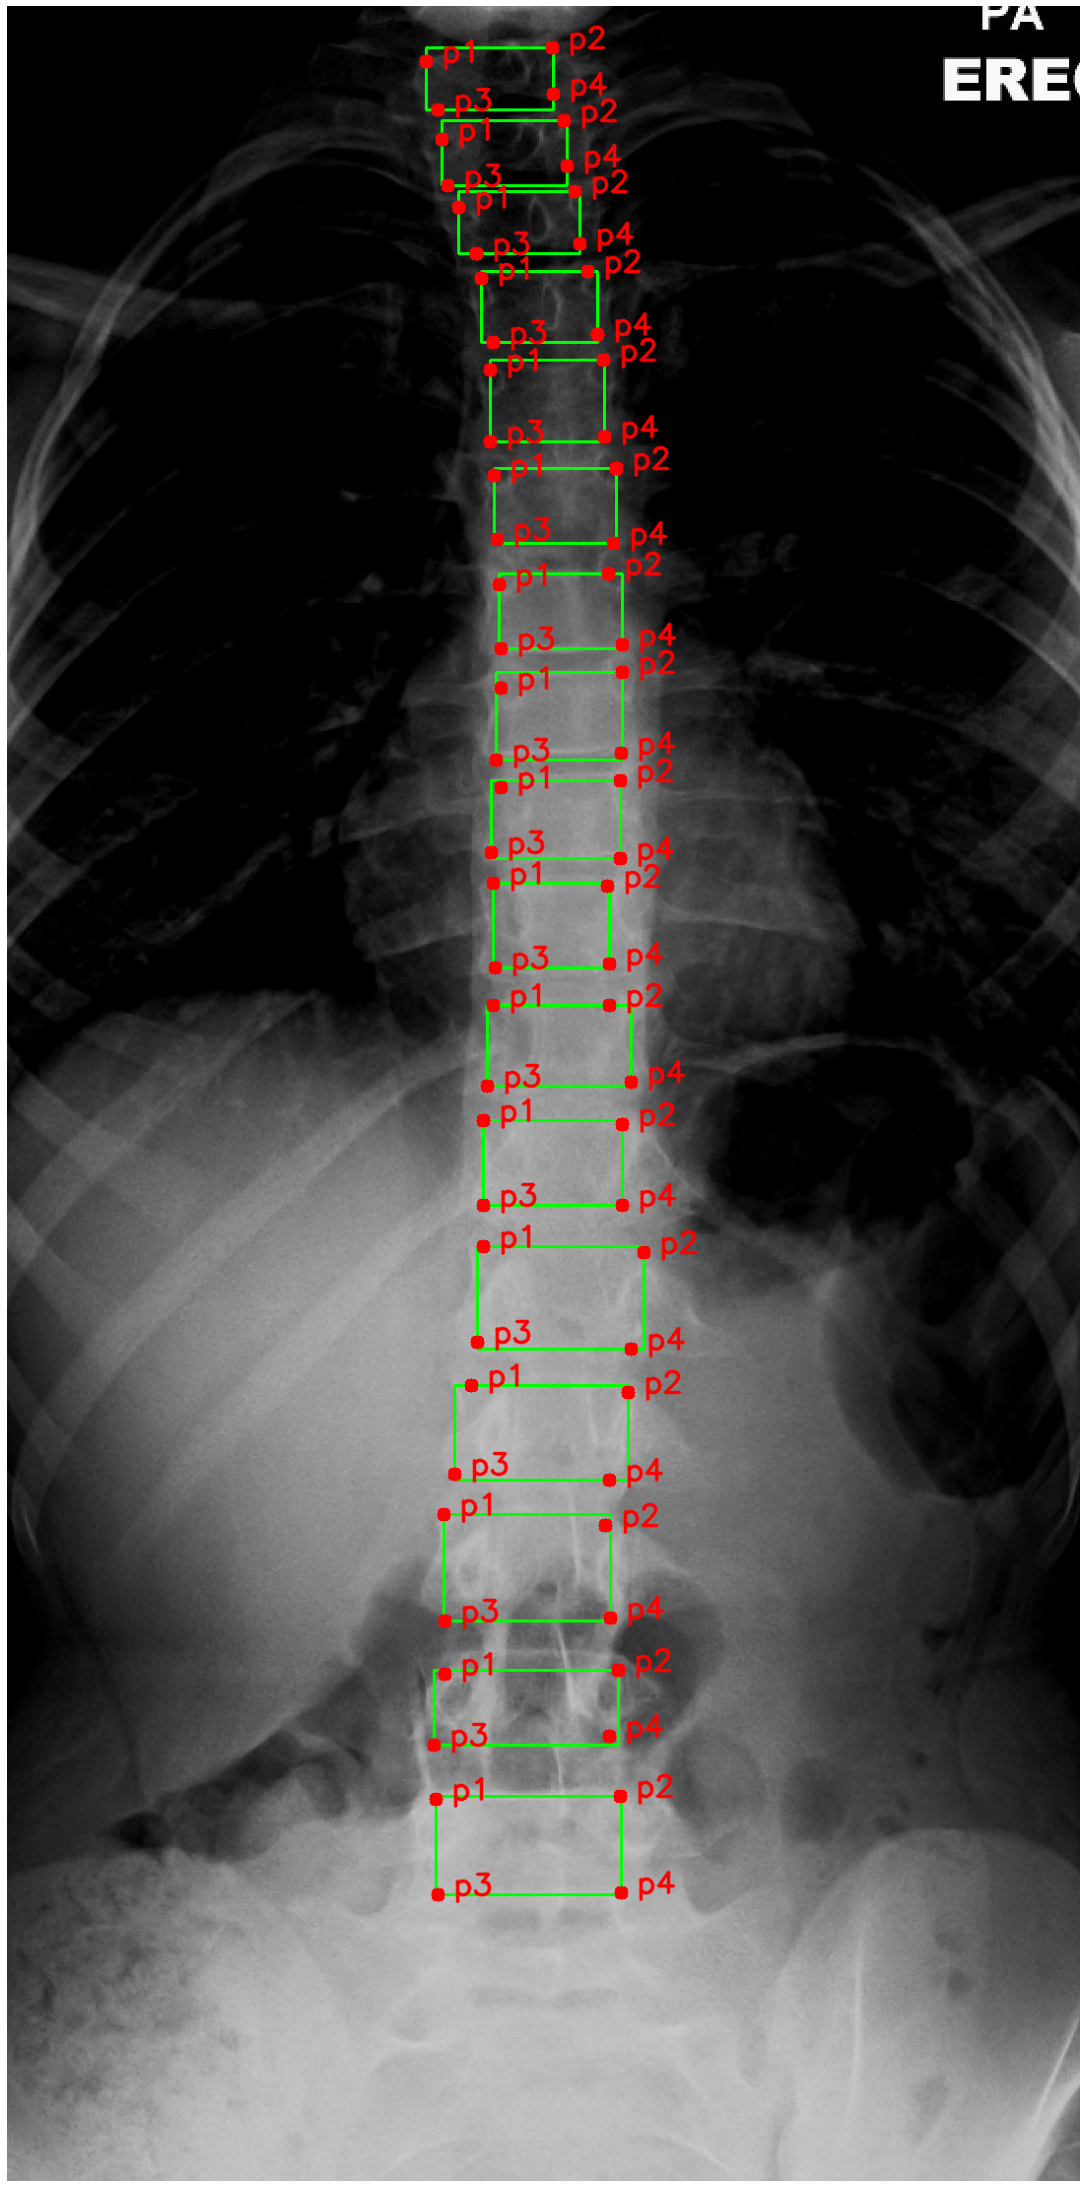

In [ ]:
keypoints_classes_ids2names = {0: 'p1', 1: 'p2', 2: 'p3', 3: 'p4'}

def visualize(image, bboxes, keypoints=None, image_original=None, bboxes_original=None, keypoints_original=None, scores=None, keypoints_scores=None, fontScale=1):
    ''' 
    [파라미터]
    image: 변환된 이미지 텐서
    bboxes: 바운딩 박스 리스트
    keypoints: 키포인트 리스트 
    image_original: 원본 이미지 
    bboxes_original: 원본 이미지의 바운딩 박스 
    keypoints_original: 원본 이미지의 키포인트 
    scores: 바운딩 박스의 신뢰도 점수 
    keypoints_scores: 키포인트의 신뢰도 점수 
    fontScale: 글씨 크기 조절
    '''
    fontsize = 18

    # bounding box 시각화 
    for idx, bbox in enumerate(bboxes):
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)   # 초록색 사각형
        if (scores != None):
          image = cv2.putText(image.copy(), f"{idx+1} vert: {scores[idx]:.2f}", start_point, cv2.FONT_HERSHEY_SIMPLEX, fontScale, (0,255,0), 2, cv2.LINE_AA)

    # keypoint 시각화 
    if (keypoints != None):
      for instance_idx, kps in enumerate(keypoints):
          for idx, kp in enumerate(kps):
              image = cv2.circle(image.copy(), tuple(kp), 2, (255,0,0), 10) # 빨간색 원 
              if (keypoints_scores != None):    # keypoint에 대한 신뢰도 점수를 텍스트로 표시 
                image = cv2.putText(image.copy(), f" {keypoints_classes_ids2names[idx]}: {keypoints_scores[instance_idx][idx]:.2f}", tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, fontScale, (255,0,0), 1, cv2.LINE_AA)
              else:
                image = cv2.putText(image.copy(), f" {keypoints_classes_ids2names[idx]}", tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, fontScale, (255,0,0), 2, cv2.LINE_AA)

    # 원본 이미지 시각화
    if image_original is None and keypoints_original is None:   # 원본 이미지와 keypoint가 없으면 변환된 이미지만
        plt.figure(figsize=(40,40))
        plt.imshow(image)
        plt.axis("off")
    else:   # 원본 이미지가 제공되면 원본 이미지에도 bounding box와 keypoint 표시 
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)

        for kps in keypoints_original:
            for idx, kp in enumerate(kps):
                image_original = cv2.circle(image_original, tuple(kp), 5, (255,0,0), 10)
                image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))    # 두 이미지를 나란히 

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)

# 이미지, bounding box, keypoint 준비
image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)

bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

# 시각화 함수 호출 
visualize(image, bboxes, keypoints)

# 5. Training

In [ ]:
def get_model(num_keypoints, weights_path=None):
    # num_keypoints : 검출할 keypoint의 수
    # weights_path : 사전 훈련된 가중치 파일의 경로 

    # 객체 탐지 모델에서 사용하는 앵커 박스 생성 : 크기, 가로 세로 비율 설정 
    # 앵커 : 객체 탐지 모델에서 사용되는 기준 박스
    # 일반적으로 고정된 위치에 배치되며, 실제 객체의 위치와 크기를 예측하기 위한 기준점 역할
    # 모델은 앵커의 위치와 크기를 조정하여 최종 바운딩 박스를 생성 
    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
    
    # 모델 생성
    # keypointrcnn_resnet50_fpn : PyTorch의 torchvision 라이브러리에서 제공하는 Keypoin R-CNN 모델, ResNet-50 기반의 Feature Pyramid Network(FPN) 사용
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,            # 모델의 전체 가중치를 사전 훈련된 상태로 로드 X
                                                                   pretrained_backbone=True,    # 백본 네트워크 (ResNet-50)의 가중치를 사전 훈련된 상태로 로드
                                                                   num_keypoints=num_keypoints, 
                                                                   num_classes = 2,             # 클래스 수, 배경(0) & 객체(1)
                                                                   rpn_anchor_generator=anchor_generator)   # 앵커 생성기 전달 
    if weights_path:    # 가중치 로드 및 모델에 적용 
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)

    return model

## 모델 구성
`torchvision.models.detection.keypointrcnn_resnet50_fpn()` 
- 객체 탐지와 keypoint 검출을 동시에 수행
- ResNet-50 백본과 FPN 아키텍처를 결합

**Keypoint R-CNN**
- 이미지에서 객체를 탐지하고, 각 객체의 특정 keypoint(예: 척추)를 검출하는 데 사용되는 딥러닝  모델
- 객체의 bounding box와 각 객체의 keypoint를 예측

### 전체 구조
#### Backbone Network: 이미지에서 특징 추출
- ResNet(Residual Network) : 딥러닝에서 사용되는 신경망 구조로, 깊은 네트워크의 학습을 용이하게 하는 잔차 학습 (residual learning)방식 사용
- ResNet-50 
    - 특징 추출기
    - 50개의 층을 가진 구조, 각 층은 잔차 블록(residual block)으로 구성되어 기울기 소실 문제를 해결
- 역할 : 모델의 백본으로 사용되며, 입력 이미지로부터 특징 맵을 추출하는 역할

**백본 네트워크**
- 특징 추출을 담당하는 네트워크
- 주어진 이미지를 받아서 중요한 특징을 추출하여 이후 객체 탐지 과정에 활용
- 예 : ResNet, VGG, EfficientNet 등    
(ResNet-50 : 50개의 층을 가진 ResNet 모델, 주로 이미지 분류와 특징 추출에 사용)


#### Feature Pyramid Network (FPN)
- 다중 스케일에서 특징을 효과적으로 결합하여 객체 탐지 성능 향상
- 백본 네트워크의 다양한 층에서 추출된 특징 맵을 사용하여 피라미드 형태로 정보를 결합 
- 작은 객체와 큰 객체 모두에 대한 정보를 포함하여 다양한 스케일의 객체를 잘 탐지 


#### Region Proposal Network (RPN): 객체가 있을 법한 영역 제안
- 이미지에서 객체가 있을 가능성이 높은 영역(Anchor boxes)을 제안
- 앵커(Anchor) 박스를 생성하고, 각 앵커에 대해 객체가 있는지 여부와 해당 객체의 바운딩 박스를 조정하는 값을 예측
- 구성
    - FPN에서 생성된 다양한 크기의 특징 맵을 기반으로 작동
    - 각 앵커에 대해 두 가지 작업을 수행:
        - 객체 여부 예측: 해당 앵커가 실제 객체를 포함하고 있는지 판단
        - 바운딩 박스 회귀: 앵커의 위치를 조정하여 실제 객체의 위치와 크기에 맞추는 작업


#### RoI Align
- RPN에서 제안된 영역(Region of Interest)을 특징 맵에 정확히 맞추기 위한 방법
- 제안된 영역의 픽셀 값을 정확하게 추출하여, 해당 영역을 FPN의 특징 맵에 정렬
    => 제안된 영역 내의 정보가 왜곡되지 않고 정확하게 사용


#### Keypoint Detection Head: 제안된 영역에서 keypoint 검출



#### Backbone Network
3. Feature Pyramid Network (FPN)
구성:
FPN은 다양한 스케일에서 정보를 결합하여 객체 탐지 성능을 향상시키기 위해 설계되었습니다.
FPN은 백본 네트워크의 여러 층에서 추출된 특징 맵을 사용하여 피라미드 형태로 특징을 생성합니다.
이 피라미드는 작은 객체와 큰 객체 모두에 대한 정보를 포함하여 다양한 스케일의 객체를 잘 탐지할 수 있도록 돕습니다.
4. Region Proposal Network (RPN)

5. RoI Align
정의:
RoI Align은 RPN에서 제안된 영역(Region of Interest)을 특징 맵에 정확히 맞추기 위한 방법입니다.
작동 방식:
RoI Align은 제안된 영역의 픽셀 값을 정확하게 추출하여, 해당 영역을 FPN의 특징 맵에 정렬합니다.
이 과정을 통해, 제안된 영역 내의 정보가 왜곡되지 않고 정확하게 사용될 수 있습니다.
6. Keypoint Detection Head
정의:
이 구성 요소는 각 객체의 키포인트를 예측하는 역할을 합니다.
구성:
Keypoint Detection Head는 RPN에서 생성된 RoI에 대해 작동하며, 각 RoI에 대해 키포인트의 위치를 예측합니다.
키포인트의 수는 num_keypoints로 정의되며, 각 객체에 대해 예측된 키포인트의 좌표와 신뢰도 점수를 반환합니다.
7. Output
결과:
모델의 최종 출력은 각 객체에 대한 바운딩 박스, 객체 클래스의 확률, 그리고 각 객체의 키포인트 좌표입니다.
각 키포인트는 해당 객체의 특정 부위(예: 사람의 팔, 다리, 얼굴 등)를 나타내며, 각 키포인트에 대한 신뢰도 점수도 포함됩니다.

In [ ]:
# Load Model and Dataset
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

dataset_train = ClassDataset(dataset_dir, "train")
dataset_test = ClassDataset(dataset_dir, "val")

data_loader_train = DataLoader(dataset_train, batch_size=3, shuffle=True, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

model = get_model(num_keypoints = 4)
model.to(device)
None

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and will be removed in 0.15, please use 'weights_backbone' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight

  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
# Training Loop
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)
num_epochs = 10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=1000)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device)

# Save model weights after training
torch.save(model.state_dict(), model_save_path)

Epoch: [0]  [  0/159]  eta: 0:24:38  lr: 0.000007  loss: 9.6229 (9.6229)  loss_classifier: 0.6682 (0.6682)  loss_box_reg: 0.1597 (0.1597)  loss_keypoint: 7.9998 (7.9998)  loss_objectness: 0.6895 (0.6895)  loss_rpn_box_reg: 0.1056 (0.1056)  time: 9.2960  data: 1.9085  max mem: 2497
Epoch: [0]  [158/159]  eta: 0:00:01  lr: 0.001000  loss: 7.1245 (8.0144)  loss_classifier: 0.3556 (0.4403)  loss_box_reg: 0.7127 (0.6122)  loss_keypoint: 5.9208 (6.5098)  loss_objectness: 0.0719 (0.3544)  loss_rpn_box_reg: 0.0888 (0.0977)  time: 1.0886  data: 0.8686  max mem: 4688
Epoch: [0] Total time: 0:02:55 (1.1012 s / it)
creating index...
index created!
Custom kpt_oks_sigmas is set
Custom kpt_oks_sigmas is set
Test:  [  0/127]  eta: 0:00:24  model_time: 0.0711 (0.0711)  evaluator_time: 0.0432 (0.0432)  time: 0.1909  data: 0.0682  max mem: 4688
Test:  [100/127]  eta: 0:00:04  model_time: 0.0591 (0.0621)  evaluator_time: 0.0412 (0.0431)  time: 0.1660  data: 0.0540  max mem: 4688
Test:  [126/127]  eta: 0:0

In [ ]:
from engine import evaluate
evaluate(model, data_loader_test, device)

creating index...
index created!
Custom kpt_oks_sigmas is set
Custom kpt_oks_sigmas is set
Test:  [  0/127]  eta: 0:15:11  model_time: 7.0671 (7.0671)  evaluator_time: 0.0314 (0.0314)  time: 7.1794  data: 0.0725  max mem: 820
Test:  [100/127]  eta: 0:00:08  model_time: 0.1517 (0.2200)  evaluator_time: 0.0349 (0.0361)  time: 0.2830  data: 0.0686  max mem: 915
Test:  [126/127]  eta: 0:00:00  model_time: 0.1518 (0.2060)  evaluator_time: 0.0305 (0.0358)  time: 0.2711  data: 0.0750  max mem: 915
Test: Total time: 0:00:39 (0.3131 s / it)
Averaged stats: model_time: 0.1518 (0.2060)  evaluator_time: 0.0305 (0.0358)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.502
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.937
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.479
 Average Precision  (AP) @

# 6. Visualizing model predictions

In [ ]:
# create iterator
iterator = iter(data_loader_test)

NameError: ignored

In [ ]:
# get batch
images, targets = next(iterator)

# set image tensor to appropriate devvice, and convert to list
images = list(image.to(device) for image in images)

# Inference
with torch.no_grad():
    model.to(device) # 1. set to device
    model.eval() # 2. set to evaluation mode
    output = model(images) # 3. get output, images must be a list of 3 tensors shape [C, H, W]

print("Predictions: \n", output)

NameError: ignored

In [ ]:
output[0]['scores'].detach().cpu().numpy()

array([0.99503446, 0.99478674, 0.9890358 , 0.98559374, 0.9853013 ,
       0.98212445, 0.98123586, 0.9793873 , 0.97697973, 0.9706343 ,
       0.96946186, 0.96358323, 0.9623158 , 0.9431274 , 0.92325205,
       0.92104197, 0.8607223 , 0.8053002 , 0.7331088 , 0.7170575 ,
       0.70269   , 0.6348731 , 0.5773405 , 0.5380261 , 0.53488857,
       0.5314441 , 0.47840354, 0.4734977 , 0.43680006, 0.3821452 ,
       0.37636977, 0.31800753, 0.26849693, 0.20873192, 0.19305788,
       0.17755944, 0.16255924, 0.16077872, 0.15843862, 0.15355685,
       0.13941258, 0.13796747, 0.1047866 , 0.09660094, 0.0945812 ,
       0.06424007, 0.05951065, 0.05277786], dtype=float32)

In [ ]:
image = (images[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores = output[0]['scores'].detach().cpu().numpy()

high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])

bboxes = []
for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))

keypoints_scores = []
for kp_scores in output[0]['keypoints_scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints_scores.append(list(kp_scores.tolist()))

scores = scores.tolist()
# for kp_scores in output[0]['scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
#     scores.append(list(kp_scores.tolist()))

visualize(image, bboxes, keypoints, scores=scores)

NameError: ignored

# 7. Inference
Creating a modular inference function so it's easier to reuse. Essentially a wrapper for model()

In [ ]:
import torch
import torchvision
from torchvision.transforms import functional as F
import numpy
from torchvision.models.detection.rpn import AnchorGenerator

def get_kprcnn_model(num_keypoints, weights_path=None):
    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   num_classes = 2, # Background is the first class, object is the second class
                                                                   rpn_anchor_generator=anchor_generator)

    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)

    return model

def _open_image_path(path):
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = F.to_tensor(img)
  return img

device = device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model(num_keypoints = 4, weights_path="/content/drive/MyDrive/models/keypointsrcnn_weights.pth")
model.to(device)

def _filter_output(output):
  # 1. Get Scores
  scores = output['scores'].detach().cpu().numpy()

  # 2. Get Indices of Scores over Threshold
  high_scores_idxs = np.where(scores > 0.5)[0].tolist() # Indexes of boxes with scores > 0.7

  # 3. Get Indices after Non-max Suppression
  post_nms_idxs = torchvision.ops.nms(output['boxes'][high_scores_idxs], output['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

  # 4. Get final `bboxes` and `keypoints` and `scores` based on indices
  np_keypoints = output['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()
  np_bboxes = output['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()
  np_scores = output['scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()

  # 5. Get the Top 17 Scores
  sorted_scores_idxs = np.argsort(-1*np_scores) # descending

  np_scores = scores[sorted_scores_idxs][:17]
  np_keypoints = np.array([np_keypoints[idx] for idx in sorted_scores_idxs])[:17]
  np_bboxes = np.array([np_bboxes[idx] for idx in sorted_scores_idxs])[:17]

  # 6. Sort by ymin
  # kp[0] is the first point in [p1,p2,p3,p4]
  # kp[0][1] is the y1 in p1=[x1,y1,x2,y2]
  ymins = np.array([kps[0][1] for kps in np_keypoints])

  sorted_ymin_idxs = np.argsort(ymins) # ascending

  np_scores = np.array([np_scores[idx] for idx in sorted_ymin_idxs])
  np_keypoints = np.array([np_keypoints[idx] for idx in sorted_ymin_idxs])
  np_bboxes = np.array([np_bboxes[idx] for idx in sorted_ymin_idxs])

  # 7. Convert everything to List Instead of Numpy
  keypoints_list = []
  for kps in np_keypoints:
      keypoints_list.append([list(map(int, kp[:2])) for kp in kps])

  bboxes_list = []
  for bbox in np_bboxes:
      bboxes_list.append(list(map(int, bbox.tolist())))

  scores_list = np_scores.tolist()

  return bboxes_list, keypoints_list, scores_list

def predict(images):
  """
  images:
    > List of Tensors, shape=[C, W, H]. Values 0-1. |
    > Numpy array of image |
    > String path to image |
    > List of String paths to images

    returns (bboxes, keypoints, scores)[] of n=17
  """
  # 1. Process `images`
  images_input = [] # List of Tensors, shape=[C, W, H]. Values 0-1.

  # 1.1 For [String path to image] & [List of String paths to images]
  if (type(images) == str):
    images_input.append(_open_image_path(images))
  elif isinstance(images, list):
    if (type(images[0]) == str):
      images_input = [_open_image_path(path) for path in images]
  elif torch.is_tensor(images):
    images_input = images
  elif isinstance(images, np.ndarray):
    print("A numpy array")
    images_input = [F.to_tensor(images)]

  images_input = [image.to(device) for image in images_input]

  # 2. Inference
  with torch.no_grad():
    model.to(device) # 1. set to device
    model.eval() # 2. set to evaluation mode
    outputs = model(images_input) # 3. get output

  filtered_outputs = [_filter_output(output) for output in outputs]

  return filtered_outputs


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and will be removed in 0.15, please use 'weights_backbone' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight

In [ ]:
image_paths = ["/content/drive/MyDrive/datasets/keypointrcnn_data/images/val/sunhl-1th-01-Mar-2017-310 C AP.jpg", "/content/drive/MyDrive/datasets/keypointrcnn_data/images/val/sunhl-1th-01-Mar-2017-310 a ap.jpg", "/content/drive/MyDrive/datasets/keypointrcnn_data/images/val/sunhl-1th-01-Mar-2017-311 A AP.jpg"]
image1 = cv2.imread(image_paths[0])
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

results = predict(image1)

A numpy array


In [ ]:
bboxes, keypoints, scores = results[0]
len(scores)

17

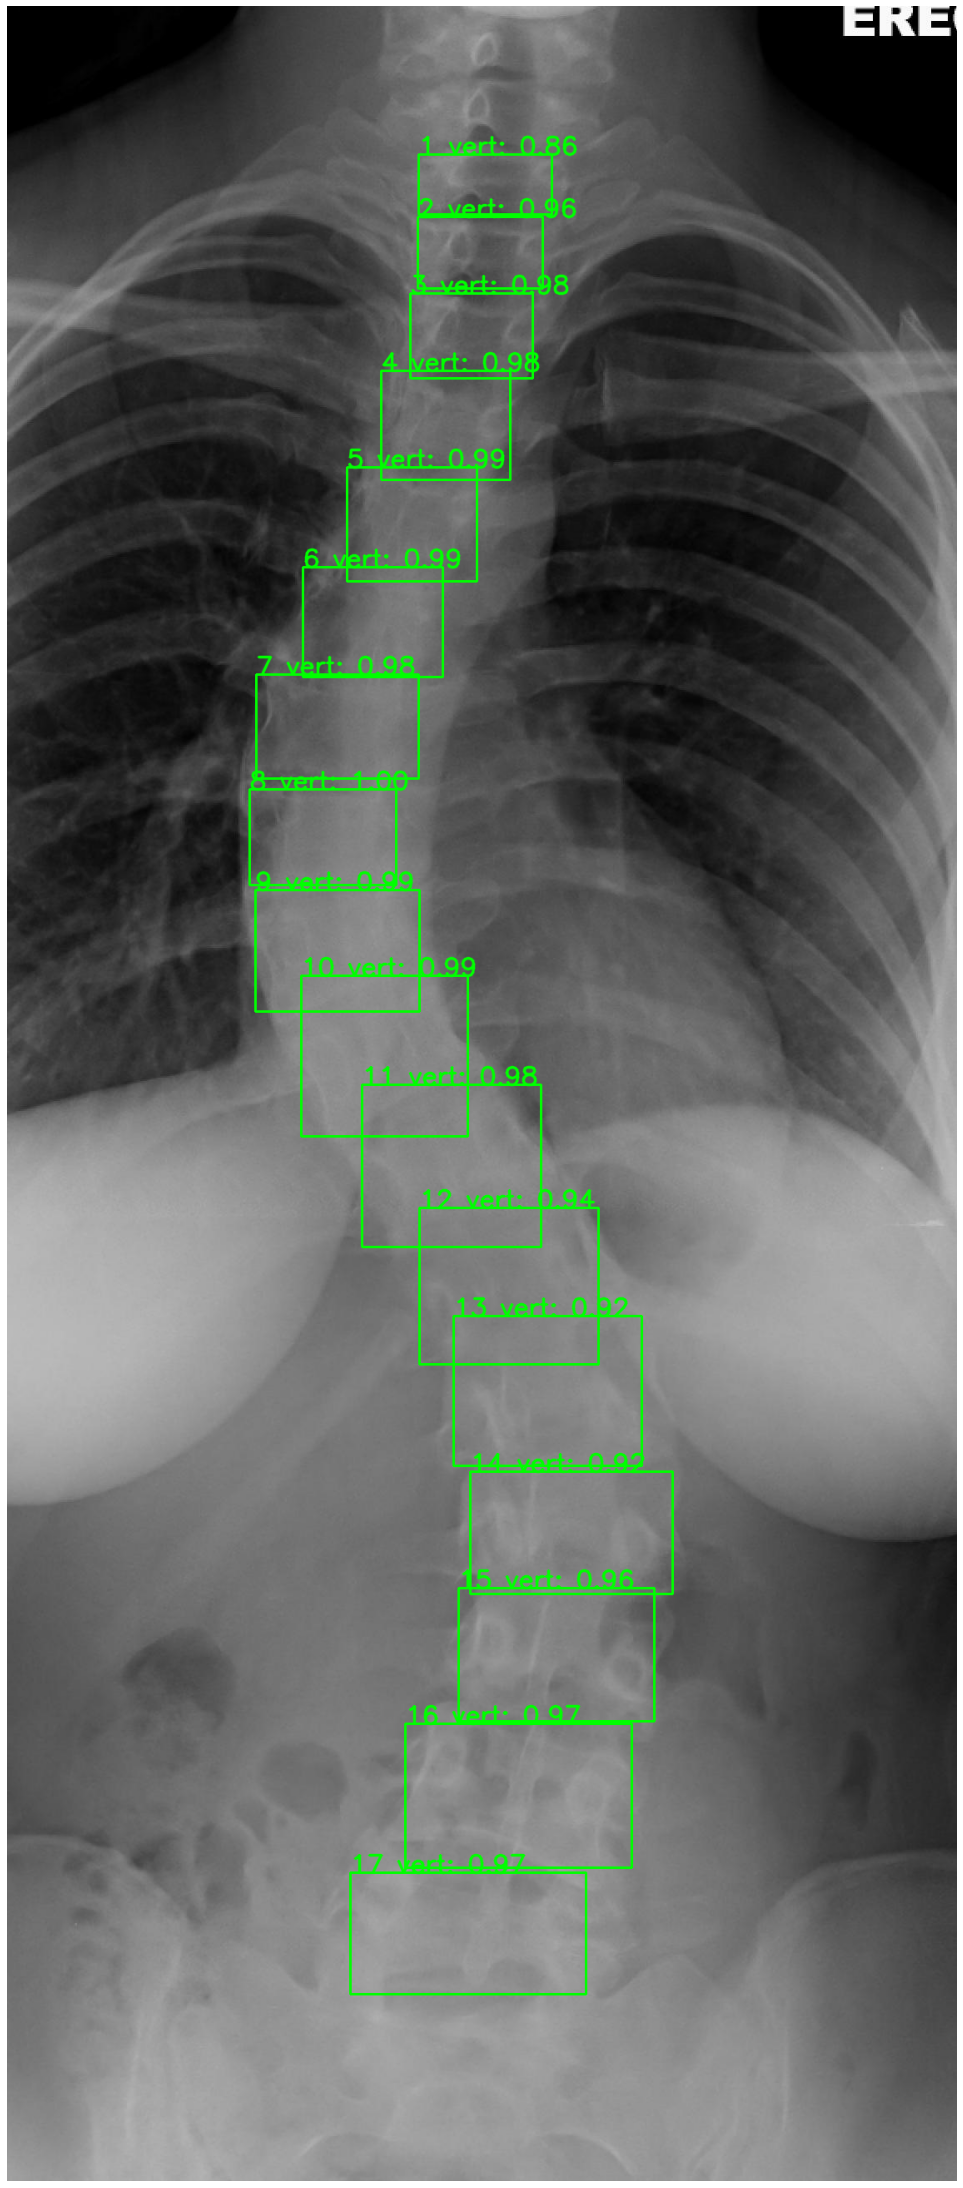

In [ ]:
image = cv2.cvtColor(cv2.imread(image_paths[0]), cv2.COLOR_BGR2RGB)

visualize(image, bboxes=bboxes, scores=scores)

In [ ]:
def kprcnn_to_scoliovis_api_format(bboxes, keypoints, scores):
  """
  detections: Array(17)
  { class: number, confidence: number, name: "vert", xmax: number, xmin: number, ymin: number, ymax: number }
  normalized_detections: Array(17)
  landmarks: Array(136)
  """
  detections = []
  for idx, bbox in enumerate(bboxes):
    detections.append({
        "class": 0,
        "confidence": scores[idx],
        "name": "vert",
        "xmin": bbox[0],
        "ymin": bbox[1],
        "xmax": bbox[2],
        "ymax": bbox[3],
    })
  landmarks = []
  for kps in keypoints:
    for kp in kps:
      landmarks.append(kp[0])
      landmarks.append(kp[1])

  return {
      "detections": detections,
      "landmarks": landmarks
  }

In [ ]:
bboxes, keypoints, scores = results[0]
kprcnn_to_scoliovis_api_format(bboxes, keypoints, scores)

{'detections': [{'class': 0,
   'confidence': 0.8607223033905029,
   'name': 'vert',
   'xmin': 494,
   'ymin': 178,
   'xmax': 654,
   'ymax': 250},
  {'class': 0,
   'confidence': 0.9623157978057861,
   'name': 'vert',
   'xmin': 493,
   'ymin': 253,
   'xmax': 643,
   'ymax': 339},
  {'class': 0,
   'confidence': 0.9769797325134277,
   'name': 'vert',
   'xmin': 484,
   'ymin': 345,
   'xmax': 631,
   'ymax': 447},
  {'class': 0,
   'confidence': 0.9793872833251953,
   'name': 'vert',
   'xmin': 449,
   'ymin': 438,
   'xmax': 604,
   'ymax': 569},
  {'class': 0,
   'confidence': 0.9855937361717224,
   'name': 'vert',
   'xmin': 408,
   'ymin': 554,
   'xmax': 564,
   'ymax': 691},
  {'class': 0,
   'confidence': 0.9853013157844543,
   'name': 'vert',
   'xmin': 355,
   'ymin': 674,
   'xmax': 523,
   'ymax': 806},
  {'class': 0,
   'confidence': 0.9812358617782593,
   'name': 'vert',
   'xmin': 299,
   'ymin': 803,
   'xmax': 494,
   'ymax': 928},
  {'class': 0,
   'confidence': 0.

## 8. Retraining

In [ ]:
# Load Model and Dataset
MODEL_PATH = '/content/drive/MyDrive/models/keypointsrcnn_weights-new.pt'
RETRAINED_MODEL_SAVE_PATH = '/content/drive/MyDrive/models/keypointsrcnn_weights-new-1pm.pt'

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

dataset_train = ClassDataset(dataset_dir, "train")
dataset_test = ClassDataset(dataset_dir, "val")

data_loader_train = DataLoader(dataset_train, batch_size=3, shuffle=True, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

model = get_model(num_keypoints = 4, weights_path=MODEL_PATH)
model.to(device)
None

In [ ]:
# Training Loop
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)
num_epochs = 50

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=1000)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device)

# Save model weights after training
torch.save(model.state_dict(), RETRAINED_MODEL_SAVE_PATH)

Epoch: [0]  [  0/159]  eta: 0:00:58  lr: 0.000007  loss: 4.4734 (4.4734)  loss_classifier: 0.1359 (0.1359)  loss_box_reg: 0.2938 (0.2938)  loss_keypoint: 4.0187 (4.0187)  loss_objectness: 0.0027 (0.0027)  loss_rpn_box_reg: 0.0224 (0.0224)  time: 0.3702  data: 0.1141  max mem: 7874
Epoch: [0]  [158/159]  eta: 0:00:00  lr: 0.001000  loss: 4.8415 (4.6805)  loss_classifier: 0.1483 (0.1422)  loss_box_reg: 0.3192 (0.3030)  loss_keypoint: 4.3011 (4.1931)  loss_objectness: 0.0107 (0.0103)  loss_rpn_box_reg: 0.0335 (0.0318)  time: 0.3175  data: 0.0939  max mem: 7874
Epoch: [0] Total time: 0:00:49 (0.3136 s / it)
creating index...
index created!
Custom kpt_oks_sigmas is set
Custom kpt_oks_sigmas is set
Test:  [  0/127]  eta: 0:00:20  model_time: 0.0490 (0.0490)  evaluator_time: 0.0292 (0.0292)  time: 0.1610  data: 0.0744  max mem: 7874
Test:  [100/127]  eta: 0:00:03  model_time: 0.0462 (0.0469)  evaluator_time: 0.0286 (0.0288)  time: 0.1396  data: 0.0570  max mem: 7874
Test:  [126/127]  eta: 0:0

In [ ]:
evaluate(model, data_loader_test, device)